In [1]:
from google.colab import files
uploaded = files.upload()

Saving sigma_sc_fitting.txt to sigma_sc_fitting.txt


/tmp/ipython-input-609299677.py:51: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  val, _ = quad(


=== Fit parameters ===
Δ(0) = 0.677 meV
A    = 1.0774

=== Goodness of fit (relative) ===
χ²        = 1.03126e-02
DOF       = 21
χ²_red    = 4.91077e-04


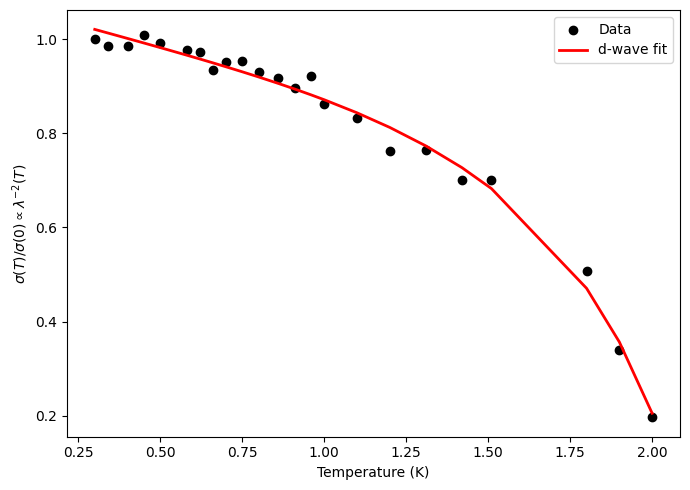


Saved fitted curve to: dwave_fit_curve.txt


In [7]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# ===== Constants =====
kB = 8.617333262e-5  # eV/K

# ===== Load experimental data (T, sigma) =====
data = np.loadtxt("sigma_sc_fitting.txt")
Tdata = data[:, 0]
sigma = data[:, 1]

# normalize: lambda^-2(T)/lambda^-2(0) ∝ sigma(T)/sigma(0)
sigma0 = sigma[0]
ydata = sigma / sigma0

# ===== Gap symmetry =====
def g_phi(phi):
    # return 1                        #s-wave
    return np.abs(np.cos(2 * phi))    #d-wave

# ===== Superconducting gap Δ(φ,T) =====
def Delta(phi, T, Delta0, Tc):
    if T >= Tc:
        return 0.0
    t = Tc / T - 1.0
    temp_factor = np.tanh(1.82 * (1.018 * t) ** 0.51)
    return Delta0 * g_phi(phi) * temp_factor

# ===== Integrand =====
def integrand_E(E, phi, T, Delta0, Tc):
    delta = Delta(phi, T, Delta0, Tc)
    if E < delta or delta == 0:
        return 0.0
    f = 1.0 / (1.0 + np.exp(E / (kB * T)))
    df_dE = -f * (1 - f) / (kB * T)
    return (E * df_dE) / np.sqrt(E**2 - delta**2)

# ===== λ^-2(T)/λ^-2(0) =====
def lambda_ratio(T, Delta0, Tc, Nphi=200):
    if T >= Tc:
        return 0.0
    phi_vals = np.linspace(0, 2 * np.pi, Nphi)
    integral_phi = 0.0
    E_max = 20 * kB * Tc
    for phi in phi_vals:
        delta = Delta(phi, T, Delta0, Tc)
        if delta <= 0:
            continue
        val, _ = quad(
            integrand_E,
            delta,
            E_max,
            args=(phi, T, Delta0, Tc),
            epsabs=1e-7,
            epsrel=1e-5,
            limit=100,
        )
        integral_phi += val
    return 1.0 + (1 / np.pi) * integral_phi * (2 * np.pi / Nphi)

# ===== Model for fitting =====
def model(T, Delta0, A):
    Tc = 2.1  # fixed
    return A * np.array([lambda_ratio(Ti, Delta0, Tc) for Ti in T])

# ===== Fit =====
popt, pcov = curve_fit(model, Tdata, ydata, p0=[3e-4, 1.0])
Delta_fit, A_fit = popt

print("=== Fit parameters ===")
print(f"Δ(0) = {Delta_fit*1e3:.3f} meV")
print(f"A    = {A_fit:.4f}")

# ===== Chi-square (unweighted) =====
yfit = model(Tdata, *popt)
chi2 = np.sum((ydata - yfit)**2)
dof = len(ydata) - len(popt)
chi2_red = chi2 / dof

print("\n=== Goodness of fit (relative) ===")
print(f"χ²        = {chi2:.5e}")
print(f"DOF       = {dof}")
print(f"χ²_red    = {chi2_red:.5e}")

# ===== Plot =====
plt.figure(figsize=(7, 5))
plt.scatter(Tdata, ydata, color="black", label="Data")
plt.plot(Tdata, yfit, 'r-', lw=2, label="d-wave fit")
plt.xlabel("Temperature (K)")
plt.ylabel(r"$\sigma(T)/\sigma(0) \propto \lambda^{-2}(T)$")
plt.legend()
plt.tight_layout()
plt.show()

np.savetxt(
    "dwave_fit_curve.txt",
    np.column_stack((Tdata, yfit))
)

print("\nSaved fitted curve to: dwave_fit_curve.txt")

In [8]:
files.download("dwave_fit_curve.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>